## About

Code to read .xml file export from Apple Health
Convert to individual csv files
Final .h5 export 

In [1]:
from datetime import date, datetime, timedelta as td
from time import mktime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import parser
import os
from tqdm import tqdm
from parse import compile
import sys
sys.path.insert(1, './../tools/')
from apple_parse import *

In [2]:
## Instructions
# 1. Set lb3_id
lb3_id = "LB3_005_phaseII"
# 2. set path_to_lb3_folder. This is where the LB3_XXx_phaseyy folder is located
path_to_lb3_folder = "/Users/jalpanchal/Documents/littlab/Data/"
path_to_lb3_folder = "/gdrive/public/DATA/Human_Data/LB3_PIONEER/"
# 3. Run all cells below

In [3]:
path_to_subject_folder = os.path.join(path_to_lb3_folder,lb3_id)
path_to_wearables = os.path.join(path_to_subject_folder,"wearables/")
path_to_preprocessed = os.path.join(path_to_wearables, "pre-processed/")
path_to_raw_activity = os.path.join(path_to_wearables,"raw/apple_health_export/")
path_to_activity_csvs = os.path.join(path_to_preprocessed,"activity/")

In [4]:
###
import xml.etree.ElementTree as ET

In [5]:
# creates folder for saving pre-processed data
try : 
    os.mkdir(path_to_preprocessed)
    print("Folder created")
except:
    print("Folder exists")

try : 
    os.mkdir(path_to_activity_csvs)
    print("Folder created")
except:
    print("Folder exists")

Folder exists
Folder exists


### extract csvs from export.xml

In [6]:
###
tree = ET.parse(os.path.join(path_to_raw_activity,"export.xml"))
root = tree.getroot()
record_list = [x.attrib for x in root.iter('Record')]
record_data = pd.DataFrame(record_list)

# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    record_data[col] = pd.to_datetime(record_data[col])

# Converts long-form tag to nan if non-numeric (which is the case for sleep data)
record_data['value'] = pd.to_numeric(record_data['value'], errors='coerce')

# some records do not measure anything, just count occurences
# filling with 1.0 (= one time) makes it easier to aggregate
record_data['value'] = record_data['value'].fillna(1.0)

# shorter observation names
record_data['type'] = record_data['type'].str.replace('HKQuantityTypeIdentifier', '')
record_data['type'] = record_data['type'].str.replace('HKCategoryTypeIdentifier', '')

In [7]:
record_data[(record_data['sourceName'] == 'AW1 - Pioneer Watch') & (record_data['type'] == '')]
print('The following devices have recordings:')
print(record_data['sourceName'].unique())

The following devices have recordings:
['Pioneer’s Apple\xa0Watch' 'iPhone']


In [8]:
###
sleep_data = record_data[(record_data['type'] == 'SleepAnalysis') & record_data['sourceName'].str.contains('Watch')]
for key in ['startDate','endDate','creationDate']:
    sleep_data.at[:,key] = pd.DatetimeIndex(sleep_data[key]).tz_convert('US/Eastern')
try:
    sleep_data.at[:,'sourceName'] = sleep_data['sourceName'].str.split('-').apply(lambda x: int(x[0][2]))
except:
    sleep_data.at[:,'sourceName'] = 0

sleep_data['creationDate'] = pd.DatetimeIndex(sleep_data.creationDate).day
sleep_data['sleepDuration'] = ((sleep_data['endDate'] - sleep_data.startDate).astype('timedelta64[s]'))/3600
sleep_data['nightlySum'] = sleep_data.groupby(['creationDate'])['sleepDuration'].cumsum()
sleep_data.head()

/home1/w/wojemann/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home1/w/wojemann/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

,type,sourceName,sourceVersion,device,unit,creationDate,startDate,endDate,value,sleepDuration,nightlySum
16507,SleepAnalysis,0,8.1,NaN,NaN,10,2021-12-09 22:00:35-05:00,2021-12-09 22:30:05-05:00,1.0,0.491667,0.491667
16508,SleepAnalysis,0,8.1,NaN,NaN,10,2021-12-09 22:31:35-05:00,2021-12-10 00:08:05-05:00,1.0,1.608333,2.100000
16509,SleepAnalysis,0,8.1,NaN,NaN,10,2021-12-10 00:12:05-05:00,2021-12-10 02:14:35-05:00,1.0,2.041667,4.141667
16510,SleepAnalysis,0,8.1,NaN,NaN,10,2021-12-10 02:28:05-05:00,2021-12-10 04:58:35-05:00,1.0,2.508333,6.650000
16511,SleepAnalysis,0,8.1,NaN,NaN,10,2021-12-10 05:38:05-05:00,2021-12-10 05:39:05-05:00,1.0,0.016667,6.666667


In [9]:
sleep_data.sourceName.unique()

array([0])

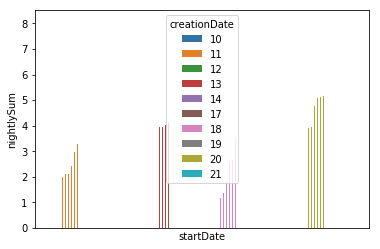

In [10]:
sns.barplot(x = sleep_data.startDate,y=sleep_data.nightlySum,hue=sleep_data.creationDate)

# locs,labels = plt.xticks()
# plt.plot(sleep_data.startDate,sleep_data.sleepDuration)
plt.xticks([]);
# plt.set_xticklabels(sleep_data.startDate.apply(datetime.time))
# plt.xlabel();

In [11]:
sleep_output = sleep_data[['startDate','endDate','creationDate',
                           'sleepDuration','nightlySum']].set_index(['startDate']).sort_index()
sleep_output.index.rename('timeStamp',inplace=True)

In [12]:
sleep_output.iloc[0,0]

Timestamp('2021-12-09 22:30:05-0500', tz='US/Eastern')

## Fetch Meta data to trim

In [13]:
meta_data = pd.read_csv(os.path.join(path_to_wearables, "wearables_metadata.csv"))

In [14]:
meta_data

,property,value
0,lb3_id,LB3_005_phaseII
1,watch_hand,right
2,study_start,12-09-2021 16:30
3,study_end,12-21-2021 20:05


## Trimming Sleep

In [15]:
str_time = pd.to_datetime(meta_data['value'][meta_data['property']=='study_start'].values[0]).tz_localize('US/Eastern')
end_time = pd.to_datetime(meta_data['value'][meta_data['property']=='study_end'].values[0]).tz_localize('US/Eastern')

In [16]:
sleep_output = sleep_output[(sleep_output.index>=str_time) & (sleep_output.index<=end_time)]

## Saving Sleep

In [17]:
path_to_save_ansdata = os.path.join(path_to_preprocessed,"watch_sleep.csv")
# #write dataframe to h5
# sleep_output.to_hdf(path_to_save_ansdata, key="sleep", mode ='w')
sleep_output.to_csv(path_to_save_ansdata)

## Plotting Sleep

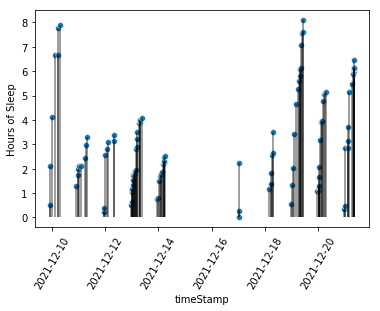

In [18]:
sns.scatterplot(x = sleep_output.index, y = sleep_output.nightlySum)
plt.xticks(rotation=60)
plt.vlines(sleep_output.index,0,sleep_output.nightlySum, alpha = .5)
plt.ylabel('Hours of Sleep');

In [19]:
sleep_summary = pd.DataFrame()

sleep_summary['numWakes'] = sleep_output.groupby(['creationDate'])['nightlySum'].count()-1
sleep_summary.reset_index(inplace=True)
sleep_output['clipNumREM'] = sleep_output['sleepDuration']//1.5
sleep_summary.loc[:,'numRem'] = sleep_output.groupby(['creationDate'])['clipNumREM'].sum().to_numpy()
sleep_summary.set_index(['creationDate'],inplace=True)
sleep_summary.head(20)

,numWakes,numRem
creationDate,,
10,6,3.0
11,7,0.0
12,6,1.0
13,22,0.0
14,12,0.0
17,2,1.0
18,5,0.0
19,14,0.0
20,13,0.0


In [20]:
sleep_summary.to_csv(os.path.join(path_to_preprocessed,"watch_sleep_summary.csv"))